# Predictive Delay Analytics

## 1. Predicting whether a flight is late

### 1.0 Data acquisition and cleaning

In [67]:
%matplotlib inline
# import required modules for prediction tasks
import numpy as np
import pandas as pd
import math
import random

In [2]:
%%time
# reads all predefined months for a year and merge into one data frame
rawData2014 = pd.DataFrame.from_csv('cache/predictionData/complete2014Data.csv')

Wall time: 1min 22s


In [ ]:
print rawData2014.columns
rawData2014.head(5)

#### Cleaning the data

When cleaning the data set, we have to remove the following entries:

- flights that have been cancelled or diverted. We focus on predicting the delay. As a result, we also remove the columns associated with diverted flights.
- colmuns that give the answer. This is the case of many colmuns related to the arrival of the plane
- rows where a value is missing

Note that data points have to be cleaned in this order because most flights have empty entries for the 'diverted' columns.

In [ ]:
#entries to be dropped in the analysis
columns_dropped = ['index', 'TAIL_NUM', 'FL_NUM', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', \
                   'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'CANCELLED', 'CANCELLATION_CODE', 'AIR_TIME', \
                   'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

In [ ]:
def clean(data, list_col):
    ''' 
    Creates a dataset by excluding undesirable columns

    Parameters:
    -----------

    data: pandas.DataFrame
       Flight dataframe  

    list_col: <list 'string'>
        Comumns to exclude from the data set
    '''
    
    data.drop(data[data.CANCELLED == 0].index, inplace=True)
    data.drop(list_col, axis=1, inplace=True)
    data.dropna(axis = 0, inplace = True)
    return

In [ ]:
%%time
data2014 = clean(rawData2014.copy(), columns_dropped)
print data2014.columns

In [ ]:
%%time
# save the data to avoid computing them again
file_path = "cache/predictionData/predictionData2014.csv"
data2014.to_csv(path_or_buf= file_path)

In [21]:
%%time
# recover data2014 from cache/predictionData folder
file_path = "cache/predictionData/predictionData2014.csv"
data2014 = pd.read_csv(file_path)
data2014.drop('Unnamed: 0', axis= 1, inplace = True)
data2014.columns

Wall time: 11.2 s


In [ ]:
# test that clean did the job
print "size of raw data set: ", len(rawData2014)
print "number of cancelled: ", len(rawData2014[(rawData2014.CANCELLED == 1)])
print "size of data set: ", len(data2014)

Let's add an example that we will follow all along. The example looks a ta flight from New York to Chicago.

In [22]:
dexample = data2014[data2014.DEST == 'ORD'][(data2014.ORIGIN == 'JFK')  | (data2014.ORIGIN == 'LGA') | \
                                              (data2014.ORIGIN == 'EWR')].copy()

dexample.head(3)

,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,DISTANCE,AIRCRAFT_YEAR,AIRCRAFT_MFR,LAT,LONG
2033,2014-01-01,AA,LGA,ORD,700,850,-17,733,1991,MCDONNELL DOUGLAS,40.766667,-73.866667
2034,2014-01-04,AA,LGA,ORD,700,850,32,733,2007,FRIEDEMANN JON,40.766667,-73.866667
2035,2014-01-05,AA,LGA,ORD,700,850,11,733,2007,FRIEDEMANN JON,40.766667,-73.866667


#### Restricting the dataset

The dataset has more than 4 millions entries, which makes any data manipulation extremely costly - let alone model fitting. We will therefore make some restrictions on the airports and the airlines considered.

In [14]:
data2014.groupby('UNIQUE_CARRIER').size()

UNIQUE_CARRIER
AA    137960
AS    157312
B6    225303
DL    644768
EV    616920
F9     81758
FL     69486
HA     73370
MQ      2995
OO    586067
UA    471093
US    381688
VX     57056
WN    597821
dtype: int64

We are only interested in the carrier that operates from New York to Chicago. Looking at the table, we also notice that Atlantic Southeast Airlines (airline code EV) is only marginally present. So we drop it from the list of carriers we will study in addition to the other carriers that do not operate on the line.

In [15]:
dexample.groupby('UNIQUE_CARRIER').size()

UNIQUE_CARRIER
AA     126
B6     955
EV       2
OO     191
UA    6821
dtype: int64

In [16]:
def restrict_carrier(data, droplist):
    ''' 
    Drop carriers from the data set.

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe  

    droplist: <list 'string'>
        List of carriers to be droppped
    '''        
    
    for item in droplist:
        data.drop(data[data.UNIQUE_CARRIER == item].index, inplace= True)
    return 

In [23]:
%%time
drop_airline = [ 'AS','DL', 'EV', 'F9', 'FL', 'HA', 'MQ', 'US', 'VX', 'WN']
restrict_carrier(data2014, drop_airline)
print "number of points", len(data2014)
print "airlines", set(data2014.UNIQUE_CARRIER)

number of points 1420423
airlines set(['AA', 'OO', 'B6', 'UA'])
Wall time: 10.5 s


We now focus on the main airports. We look for airports that have on average 50 domestic flight everyday.

In [24]:
def restrict_example(data):
    ''' 
    Restrict dataset to airports for the example
    '''  
    
    data.drop(data[(data.ORIGIN != 'JFK') & (data.ORIGIN != 'LGA') & (data.ORIGIN != 'EWR') & \
                  (data.DEST != 'ORD')].index, inplace=True)
    return

In [26]:
%%time
restrict_example(data2014)
print "number of points", len(data2014)

number of points 205309
Wall time: 1.44 s


In [ ]:
#remove all airports that have an annual traffic under threshold

def restrict_airport(data, threshold):
    ''' 
    Drop carriers from the data set.

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe  

    droplist: <list 'string'>
        List of carriers to be droppped
    '''     
    
    dict_count = data.groupby("DEST").agg(['count']).LAT.to_dict()['count']
    
    for key in dict_count:
        if dict_count[key] < threshold:
            data.drop(data[data.DEST == key].index, inplace=True)
            data.drop(data[data.ORIGIN == key].index, inplace=True)
    
    print data.groupby("DEST").agg(['count']).LAT.to_dict()['count']
    
    return

** WARNING ** \
RUN THIS CELL ONLY ONCE!

In [27]:
%%time
#restrict_airport(data2014, 60*365)
data_example = data2014.copy()
print "number of airports: ", len(set(data2014))
print "dataset size: ", len(data2014)

number of airports:  12
dataset size:  205309
Wall time: 19 ms


In [28]:
%%time
# save the restricted data to avoid computing them again
file_path = "cache/predictionData/data_example.csv"
data_example.to_csv(path_or_buf= file_path)

Wall time: 1.41 s


In [29]:
data_example.head(3)

,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,DISTANCE,AIRCRAFT_YEAR,AIRCRAFT_MFR,LAT,LONG
0,2014-01-01,AA,JFK,LAX,900,1225,13,2475,1987,BOEING,40.633333,-73.783333
1,2014-01-02,AA,JFK,LAX,900,1225,1,2475,1987,BOEING,40.633333,-73.783333
2,2014-01-04,AA,JFK,LAX,900,1225,59,2475,1986,BOEING,40.633333,-73.783333


In [ ]:
#%%time
# recover file
#file_path = "cache/predictionData/dataRes.csv"
#dataRes = pd.read_csv(file_path)
#dataRes.drop('Unnamed: 0', axis= 1, inplace = True)
#print dataRes.columns

#### Encoding categorical variables

In [30]:
from time import strptime
days = {0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"}
months = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"June", 7:"July", 8:"Aug", 9:"Sep", \
          10:"Oct", 11:"Nov", 12:"Dec"}

In [31]:
def adjust_time(data):
    monlist = np.empty(len(data), dtype = str)
    daylist = np.empty(len(data), dtype = str)
    
    for i in xrange(len(data)):
        date= strptime(data.FL_DATE.iloc[i], "%Y-%M-%d")
        monlist[i] = months[date.tm_min]
        daylist[i] = days[date.tm_wday]

    return monlist, daylist

In [34]:
data_example.columns

Index([u'FL_DATE', u'UNIQUE_CARRIER', u'ORIGIN', u'DEST', u'CRS_DEP_TIME',
       u'CRS_ARR_TIME', u'ARR_DELAY', u'DISTANCE', u'AIRCRAFT_YEAR',
       u'AIRCRAFT_MFR', u'LAT', u'LONG'],
      dtype='object')

In [35]:
%%time
monlist, daylist = adjust_time(data_example)
print "OK"
data_example['MONTH'] = pd.Series(monlist, index=data_example.index)
data_example['DAY'] = pd.Series(daylist, index=data_example.index)
if 'FL_DATE' in data_example.columns:
    data_example.drop('FL_DATE', axis = 1, inplace= True)
print data_example.columns

OK
Index([u'UNIQUE_CARRIER', u'ORIGIN', u'DEST', u'CRS_DEP_TIME', u'CRS_ARR_TIME',
       u'ARR_DELAY', u'DISTANCE', u'AIRCRAFT_YEAR', u'AIRCRAFT_MFR', u'LAT',
       u'LONG', u'MONTH', u'DAY'],
      dtype='object')
Wall time: 10.7 s


In [36]:
%%time
monlist, daylist = adjust_time(dexample)
print "OK"
dexample['MONTH'] = pd.Series(monlist, index=dexample.index)
dexample['DAY'] = pd.Series(daylist, index=dexample.index)
if 'FL_DATE' in dexample.columns:
    dexample.drop('FL_DATE', axis = 1, inplace= True)
print dexample.columns

OK
Index([u'UNIQUE_CARRIER', u'ORIGIN', u'DEST', u'CRS_DEP_TIME', u'CRS_ARR_TIME',
       u'ARR_DELAY', u'DISTANCE', u'AIRCRAFT_YEAR', u'AIRCRAFT_MFR', u'LAT',
       u'LONG', u'MONTH', u'DAY'],
      dtype='object')
Wall time: 445 ms


#### Adjusting numerical data

Let's change the script to put time in minutes.

In [37]:
%%time
ti = lambda x: x/100*60+x%100
data_example['CRS_ARR_TIME_COR'] = data_example.CRS_ARR_TIME.map(ti)
data_example['CRS_DEP_TIME_COR'] = data_example.CRS_DEP_TIME.map(ti)
data_example.drop(['CRS_DEP_TIME', 'CRS_ARR_TIME'], axis = 1, inplace = True)

before change:  0    1225
1    1225
Name: CRS_ARR_TIME, dtype: int64

after change:  0    745
1    745
Name: CRS_ARR_TIME_COR, dtype: int64
Wall time: 825 ms


In [38]:
%%time
dexample['CRS_ARR_TIME_COR'] = dexample.CRS_ARR_TIME.map(ti)
dexample['CRS_DEP_TIME_COR'] = dexample.CRS_DEP_TIME.map(ti)
dexample.drop(['CRS_DEP_TIME', 'CRS_ARR_TIME'], axis = 1, inplace = True)

Wall time: 92 ms


We need to center and normalize all continuous data

In [39]:
# # change the age of the aircraft from a string type to an integer type
data_example.drop(data_example[data_example.AIRCRAFT_YEAR =='    '].index, inplace = True)
data_example['AIRCRAFT_YEAR_COR'] = data_example.AIRCRAFT_YEAR.map(lambda x: int(x))
data_example.drop('AIRCRAFT_YEAR', axis = 1, inplace = True)

In [40]:
dexample.drop(dexample[dexample.AIRCRAFT_YEAR =='    '].index, inplace = True)
dexample['AIRCRAFT_YEAR_COR'] = dexample.AIRCRAFT_YEAR.map(lambda x: int(x))
dexample.drop('AIRCRAFT_YEAR', axis = 1, inplace = True)

In [41]:
def normalize(array):
    mean = np.mean(array)
    std = np.std(array)
    return [(x - mean)/std for x in array]

In [42]:
def normalize_data(data, feature_list):
    ''' 
    Normalize data.

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe  

    feature_list: <list 'string'>
        List of features to be normalized
    '''           

    for feature in feature_list:
        if feature in data.columns:
            data[feature + '_NOR'] = normalize(data[feature].values)
            data.drop(feature, axis =1, inplace=True)
    return

In [92]:
%%time
normalize_feature = ['CRS_DEP_TIME_COR', 'CRS_ARR_TIME_COR', 'DISTANCE', 'LONG', 'LAT', 'AIRCRAFT_YEAR_COR']
normalize_data(data_example, normalize_feature)
normalize_data(dexample, normalize_feature)

Wall time: 35 ms


We are only interested in whetehr a flight will be more than 15 minutes late. So we adjust the ARR_DELAY colum to an indicator.

In [44]:
#data_example['ARR_DELAY_COR'] = data_example.ARR_DELAY.map(lambda x: (x >= 15))
#data_example.drop('ARR_DELAY', axis = 1, inplace = True)

#### Encode categorical variables

In [45]:
encoded_list = ['UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'AIRCRAFT_MFR', 'MONTH','DAY']

In [46]:
%%time
finalData_example = pd.get_dummies(data_example, columns=encoded_list)

Wall time: 1.84 s


In [48]:
%%time
# save the restricted data to avoid computing them again
file_path = "cache/predictionData/finalData_example.csv"
finalData_example.to_csv(path_or_buf= file_path)

Wall time: 23.8 s


In [49]:
#%%time
# recover data2014 from cache/predictionData folder
#file_path = "cache/predictionData/finalData.csv"
#finalData = pd.read_csv(file_path)
#finalData.drop('Unnamed: 0', axis= 1, inplace = True)

### 1.1 Baseline classifiers

We will make prediction on the variable 'ARR_DEL15'. This variable takes the value 1 is the plane is more than 15 minutes late and 0 if not. Let's look at the baseline classifier, that is the classifiers that assign repectively 1 or 0 to 'ARR_DEL15' for every flight.

In [50]:
from __future__ import division

def baseline(data, target):
    ''' 
    Compute the baseline classifiers along a target variable for a data set data

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe  

    target: string
        Column of data along wich we compute the baseline classifiers
    '''    
    
    
    score_baseline_1 = np.size(data[data[target] == 1][target].values) / np.size(data[target].values)
    score_baseline_0 = np.size(data[data[target] == 0][target].values) / np.size(data[target].values)
    
    print "baseline classifier everyone to 0: ", int(score_baseline_0*100) , "%"
    print "baseline classifier everyone to 1: ", int(score_baseline_1*100) , "%"
   
    return score_baseline_0, score_baseline_1

In [51]:
#score_baseline_0, score_baseline_1 = baseline(finalData_example, 'ARR_DELAY_COR')

#### Split data into training/test sets

First, let's split the data set into a training set and a test set. 

In [52]:
from sklearn.cross_validation import train_test_split

In [53]:
def split(data, list_drop, target, test_size):
    ''' 
    Splits the data into a training and a test set
    Separates the training and test sets according to a feature set and a target set
    Balance the features sets by retaining only fraction of its points

    Parameters:
    -----------

    data: pandas.DataFrame
       Flight dataframe  

    list_drop: <list 'string'>
        List of columns to exclude from the features set
        
    target: string
        target column along whch we make the target set
        
    test_size: float
        size of the test set
    
    '''    
    
    #split the dataset into a training set and a test set
    dtrain, dtest = train_test_split(data, test_size = 0.3)
    
    Xtrain = dtrain.drop(list_drop, axis=1).values
    ytrain = dtrain[target].values
    Xtest = dtest.drop(list_drop, axis=1).values
    ytest = dtest[target].values
    
    return Xtrain, ytrain, Xtest, ytest

In [54]:
finalData_example.columns

Index([u'ARR_DELAY', u'CRS_DEP_TIME_COR_NOR', u'CRS_ARR_TIME_COR_NOR',
       u'DISTANCE_NOR', u'LONG_NOR', u'LAT_NOR', u'AIRCRAFT_YEAR_COR_NOR',
       u'UNIQUE_CARRIER_AA', u'UNIQUE_CARRIER_B6', u'UNIQUE_CARRIER_OO', 
       ...
       u'MONTH_J', u'MONTH_M', u'MONTH_N', u'MONTH_O', u'MONTH_S', u'DAY_F',
       u'DAY_M', u'DAY_S', u'DAY_T', u'DAY_W'],
      dtype='object', length=227)

In [55]:
Xtrain, ytrain, Xtest, ytest = split(finalData_example, ['ARR_DELAY'], 'ARR_DELAY', 0.4)

## 2. Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [86]:
def score_random_forest(Xtrain, ytrain, Xtest, ytest, n_trees=10, max_features='auto'):
    ''' 
    Fits a random forest with (Xtrain ,ytrain)
    Computes the score on (Xtest, ytest)

    Parameters:
    -----------

    Xtrain: numpy 2D array
       Feature training set

    ytrain: numpy 1D array
        Target training set
    
    Xtest: numpy 2D array
       Feature test set

    ytest: numpy 1D array
        Target test set
    
    n_trees: int
        number of trees in the forest
    
    max_features: string or int
        number of features used for every tree
        
    Outputs:
    --------
    
    score_train: float
        score on the train set
    
    score_test: float
        score on the test set
    
    clf.feature_importances_
        weights of each feature as used by the classifier
    
    ''' 

    clf= RandomForestRegressor(n_estimators=n_trees, max_features= max_features)
    clf.fit(Xtrain, ytrain)
    
    score_train = mean_squared_error(clf.predict(Xtrain), ytrain)
    score_test = mean_squared_error(clf.predict(Xtest), ytest)
    
    return  score_train, score_test, clf

In [87]:
def best_parameters(Xtrain, ytrain, Xtest, ytest, nb_trees, nb_features):
    ''' 
    Fits sequentially random forest classifiers
    Adds each test score in a pandas.DataFrame with the number of trees, the loss function, the train score,
    and the importance of each features
    Returns a DataFrame with all scores

    Parameters:
    -----------

    Xtrain: numpy 2D array
       Feature training set

    ytrain: numpy 1D array
        Target training set
    
    Xtest: numpy 2D array
       Feature test set

    ytest: numpy 1D array
        Target test set
    
    n_trees: <list int>
        list of numbers of trees in the forest
    
    nb_features: <list int>
        list of number of features in the forest
        
    Outputs:
    --------
    
    score_tab: pandas.DataFrame
        DataFrame of scores with associated parameters
    
    '''
    
    score_tab = pd.DataFrame(columns=['nb_trees', 'nb_features', 'test_score', 'train_score', 'classifier'])
    
    # counter will increment the index in score_tab
    counter = 0 

    for n_estimators in nb_trees:
        for max_features in nb_features:

            score_train, score_test, classifier = \
            score_random_forest(Xtrain, ytrain, Xtest, ytest, n_trees=n_estimators, max_features=max_features) 
            score_tab.loc[counter] = [n_estimators, max_features, score_test, score_train, classifier]
            counter += 1

    return score_tab

In [88]:
def classify_random_forest(data, list_drop, target, test_size=0.4, nb_trees=[10], nb_features = ['auto']):
    Xtrain, ytrain, Xtest, ytest = split(data, list_drop, target, test_size)
    scores =  best_parameters(Xtrain, ytrain, Xtest, ytest, nb_trees, nb_features)
    return scores

In [98]:
nb_trees = [50]
nb_features = ['log2']
test_size = 0.4

In [99]:
%%time
randomForest2014 =  classify_random_forest(finalData_example, ['ARR_DELAY'], 'ARR_DELAY', test_size=test_size, nb_trees=nb_trees, nb_features=nb_features)
print randomForest2014.head(3)

   nb_trees nb_features   test_score  train_score  \
0        50        log2  2344.664596   549.668531   

                                          classifier  
0  (DecisionTreeRegressor(criterion='mse', max_de...  
Wall time: 3min 14s


In [ ]:
# save file to /data/ folder
file_path = "cache/predictionData/randomForest2014.csv"
randomForest2014.to_csv(path_or_buf= file_path)

### Important coefficients

Let's now look at the importance coefficients, that the average usage of each coefficients in the random forest.

In [ ]:
best_clf = randomForest2014[randomForest2014.test_score = np.max(randomForest2014.test_score.values)].classifier.values

In [ ]:
Xexample = dexample.drop(list_drop, axis=1).values
yexample = dexample[target].values

### Predictions and ROC curves

*Describe Process*

# 3. Predicting flight delay time with Linear Regression

To allow users to enjoy more than a classfication experience we want to give them an expected delay time in minutes.

In [19]:
%matplotlib inline
# import required modules for prediction tasks
import numpy as np
import pandas as pd
import math
import random
import requests
import zipfile
import StringIO
import re
import json
import os
import matplotlib
import matplotlib.pyplot as plt

# sklearn functions used for the linear regression model
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error

First, let us again establish a baseline which has to be beaten by our model. To get a feeling for a good baseline we pick flights from from New York(all airports) to Chicago(all airports).

In [30]:
# first step is to load the actual data and exclude rows that are unnecessary
# a script that produces the csv file can be found in the src folder
# (it might take some while to run, on my macbook up to one hour)
print('loading data...')
bigdf = pd.read_csv('cache/Big5FlightTable.csv')

years = ['2010', '2011', '2012', '2013', '2014']

loading data...


In [31]:
# specify here which cities should be investigated
city_from = 'New York, NY'
city_to = 'Chicago, IL'

# filter for cities
bigdf = bigdf[(bigdf.ORIGIN_CITY_NAME == city_from) & (bigdf.DEST_CITY_NAME == city_to)]

### 3.1. A first predictor
For a span of days we are interested in knoweledge, which flight we should take. Therefore let's choose the popular date for Christmas returning flights 21.12.2015 as example. As we want to use historical data, let's get first clear what data we have. Is it possible to compare flights over the years?

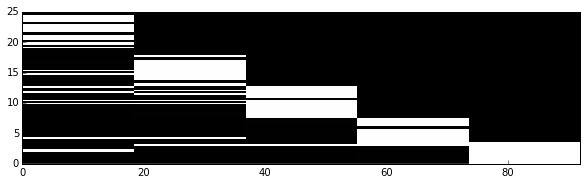

In [32]:
query_day = 21
query_month = 12

# how many flights do exist in all years?
flights = []
flightvalues = []
for y in years:
    query = list(bigdf[(bigdf.YEAR == int(y)) & (bigdf.MONTH == query_month) & (bigdf.DAY_OF_MONTH == query_day)].FL_NUM.astype(int).unique())
    flights.append(query)
    flightvalues += query
    
# build a matrix
data_matrix = np.zeros((len(flightvalues), len(years)))
# build dict
flightdict = dict(zip(flightvalues, np.arange(0, len(flightvalues))))

# fill datamatrix
for i in xrange(len(years)):
    for j in flights[i]:
        data_matrix[flightdict[j], i] = 1.
        
# plot matrix
plt.figure(figsize=(10, 6))
plt.imshow(data_matrix, extent=[0,data_matrix.shape[0],0,data_matrix.shape[1] * 5], \
           interpolation='none', cmap='gray')

As the plot shows, flight numbers are not stable over the years and it is not trivial to find a matching.
Thus comparison by features for individual flights is not really possible. 
It seems as if airlines change their flight numbers on a yearly basis. 
Thus we need to come up with another idea and use a latent variable based approach instead.
One of the easiest ideas is to average the delay time over each day as a base classifier and refine then.

In [34]:
dffordate = bigdf[bigdf.MONTH == query_month]
dffordate = dffordate[dffordate.DAY_OF_MONTH == query_day]
dffordate.head()

def predict_base_model(X):
    return np.array([dffordate.ARR_DELAY.mean()]*X.shape[0])

To test the quality of this model, we use the last year as test set and the previous as train data. The idea is, that we are always interested in predicting the next year somehow. Thus, if the match for 2014 is good, we expect it to be the same for 2015.

In [70]:
# build test/train set
df_train = dffordate[dffordate.YEAR != int(years[-1])]
df_test = dffordate[dffordate.YEAR == int(years[-1])]

y_train = df_train.ARR_DELAY
X_train = y_train # here dummy
y_test = df_test.ARR_DELAY
X_test = y_test # here dummy

In the base model, the prediction for 2014 is that we are going to be 27.72 minutes late

In [71]:
y_pred = predict_base_model(X_test)
y_pred[0]

27.728260869565219

How good did it perform comparing the actual arrival delay?

In [72]:
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred)**2).mean())

def mas(y, y_pred):
    return (np.abs(y - y_pred)).mean()

MAS_base = mas(y_test, y_pred)
RMSE_base = rmse(y_test, y_pred)
RMSE_base

44.10756003440288

Using the root mean squared error as one (of many possible) measures, any model that we develop should beat the benchmark of 44.

## 3.2 Building a linear regression model for prediction

As flight delay changes over the time of day like explored in the data exploration part, we introduce a new feature which models in a categorical variable 10 minute time windows. I.e. for each window we introduce a latent variable that captures some sort of delay influence of this frame. This is done for both the departure and the arrival time. The model here is first developed for the reduced dataset containing the flights between New York / Chicago only.

In [41]:
%%time
bigdf['HOUR_OF_ARR'] = 0
bigdf['HOUR_OF_DEP'] = 0

for index, row in bigdf.iterrows():
    bigdf.set_value(index, 'HOUR_OF_ARR', int(row['ARR_TIME']) / 10)
    bigdf.set_value(index, 'HOUR_OF_DEP', int(row['DEP_TIME']) / 10)

CPU times: user 3.05 s, sys: 212 ms, total: 3.27 s
Wall time: 3.37 s


In the next step, before fitting the actual model categorical variables need to be encoded as binary features (they have no order!) and numerical features shall be normalized.

In [44]:
# split data into numerical and categorical features
numericalFeat = bigdf[['DISTANCE', 'AIRCRAFT_AGE']].astype('float') 
categoricalFeat = bigdf[['MONTH', 'DAY_OF_MONTH', 'ORIGIN', 'DEST', \
                         'HOUR_OF_ARR', 'HOUR_OF_DEP', 'UNIQUE_CARRIER', \
                         'DAY_OF_WEEK', 'AIRCRAFT_MFR']] 

#### Dealing with categorical variables
Luckily, sklearn has a routine to do this for us. Yet, as it is only able to handle integers we first reindex all categorical features we create lookup tables for the values. This turned out to be one of the slowest step in processing.

In [46]:
%%time
# for the next step, all features need to be encoded as integers --> create lookup Tables!
def transformToID(df, col):
    vals = df[col].unique()
    LookupTable = dict(zip(vals, np.arange(len(vals))))
    for key in LookupTable.keys():
        df[df[col] == key] = LookupTable[key]
    return (LookupTable, df)

mfrDict, categoricalFeat = transformToID(categoricalFeat, 'AIRCRAFT_MFR')
originDict, categoricalFeat = transformToID(categoricalFeat, 'ORIGIN')
destDict, categoricalFeat = transformToID(categoricalFeat, 'DEST')
carrierDict, categoricalFeat = transformToID(categoricalFeat, 'UNIQUE_CARRIER')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CPU times: user 12.9 s, sys: 104 ms, total: 13 s
Wall time: 13.8 s


In [47]:
categoricalFeat.head()

,MONTH,DAY_OF_MONTH,ORIGIN,DEST,HOUR_OF_ARR,HOUR_OF_DEP,UNIQUE_CARRIER,DAY_OF_WEEK,AIRCRAFT_MFR
921,0,0,0,0,0,0,0,0,0
922,1,1,1,1,1,1,1,1,1
923,0,0,0,0,0,0,0,0,0
924,0,0,0,0,0,0,0,0,0
925,2,2,2,2,2,2,2,2,2


Using sklearn the variables are now encoded. As we have many variables (around 1200 in the final model for the whole year) using sparse matrices was critical for us to fit the model.

In [48]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error

In [49]:
%%time 
encoder = OneHotEncoder() 
categoricals_encoded = encoder.fit_transform(categoricalFeat)

CPU times: user 48.2 ms, sys: 10 ms, total: 58.3 ms
Wall time: 59.6 ms


Recombining categorical and numerical features allows to start the usual Machine Learning routine (split into test/train, normalize, train/cross-validate, test)

In [51]:
numericals_sparse = sparse.csr_matrix(numericalFeat)
# get data matrix & response variable
X_all = sparse.hstack((numericals_sparse, categoricals_encoded))
y_all = bigdf['ARR_DELAY'].values

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 42)

# we have 2 numerical features
X_train_numericals = X_train[:, 0:3].toarray()
X_test_numericals = X_test[:, 0:3].toarray()

# use sklearn tools to standardize numerical features...
scaler = StandardScaler() 
scaler.fit(X_train_numericals) # get std/mean from train set
X_train_numericals = sparse.csr_matrix(scaler.transform(X_train_numericals)) 
X_test_numericals = sparse.csr_matrix(scaler.transform(X_test_numericals))

# update sets
X_train[:, 0:3] = X_train_numericals
X_test[:, 0:3] = X_test_numericals

/usr/local/lib/python2.7/site-packages/scipy/sparse/compressed.py:739: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#### Ordinal least squares regression

In [54]:
clf = sklearn.linear_model.LinearRegression()

# fit the model!
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
rmse(y_test, y_pred)

48.323925698812779

In a first model, we use OLS to get a feeling of what is achievable using a reduced dataset. The motivation for this is mainly to see whether this might be used to speedup the whole process. As the RMSE reveals, we did not do better than the base classifier. What happened? 

In [57]:
X_train.shape, clf.coef_.shape

((31881, 74), (74,))

Looking at the number of variables (74 here), it might be that either the fit is not good enough or we are ignoring the dependency of flight delays within different routes.

#### Ridge regression

In [62]:
%%time
# Use ridge regression (i.e. Gaussian prior) and vary the lambda parameter using Grid search
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV

SGD_params = {'alpha': 10.0 ** -np.arange(-2,8)}
SGD_model = GridSearchCV(SGDRegressor(random_state = 42), \
                         SGD_params, scoring = 'mean_absolute_error', cv = 6) # cross validate 6 times


# train the model, this might take some time...
SGD_model.fit(X_train, y_train)

CPU times: user 2.01 s, sys: 52 ms, total: 2.06 s
Wall time: 2.14 s


In [63]:
y_pred = SGD_model.predict(X_test)
rmse(y_test, y_pred)

48.389335267933092

Looking at the RMSE again is a bit disappointing. We did worse than OLS and the base classifier! This means, it is now time to tackle the unavoidable: Regressing the whole dataset!

As the data becomes rapidly huge (for 1 year ~ 700MB uncompressed CSV, 5 years ~ 3.5GB, 10 years ~ 7.2GB) the code to perform the actual regression has been developed first in an IPython notebook and then run separately. It can be found in the `src` folder. 

### Regression over the whole data
In the following `2` models based on `1, 5` years of data are used (saved in `BigFlightTable.csv, Big5FlightTable.csv`). 

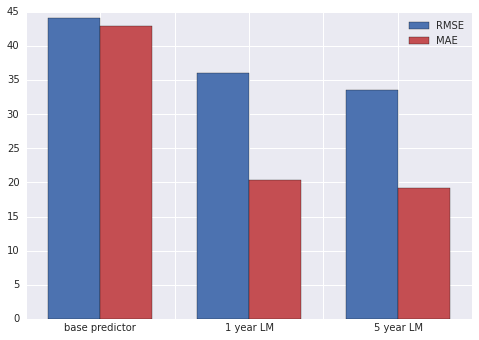

In [131]:
import json
import seaborn as sns
import matplotlib.ticker as ticker

def load_model(filename):
    mdl = None
    with open(filename, 'r') as f:
        mdl = json.load(f)
    return mdl

# load model results
mdl1 = load_model('results/models/2014model.json') # model with 2014 data (1 year)
mdl5 = load_model('results/models/2010_2014model.json') # model with 2010-2014 data ( 5 years)


labels = np.array(['base predictor', '1 year LM', '5 year LM'])
RMSEs = np.array([RMSE_base, mdl1['RMSE'], mdl5['RMSE']])
MASs = np.array([MAS_base, mdl1['MAS'], mdl5['MAS']])

width = .35
xx = np.arange(len(RMSEs))
plt.bar(xx-width, RMSEs, width, label='RMSE', color=sns.color_palette()[0])
plt.bar(xx , MASs, width, label='MAE', color=sns.color_palette()[2])
plt.legend(loc='best')

# Hide major tick labels
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.NullFormatter())

# Customize minor tick labels
ax.xaxis.set_minor_locator(ticker.FixedLocator([i for i in xx]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter([labels[i] for i in xx]))

Comparing the RMSEs and Mean absolute error we see that the linear regression model over the whole data clearly outperformed the baseline predictor. Also, more data did not really tremendously improve the mean absolute error but we can see a clear variance reduction in the RMSE. To further improve the model, additional variables should be included. One of the next ideas is weather data. As formatted historic weather data is unfortunately not for free available and scraping it for 100Ks entries per year is not feasible, the variables could not be added to the model. Another interesting idea might be to include some more meta data. I.e. an variable measuring the effect of holidays and variables accounting for winds which could be based by geographic location (i.e. a flight in western direction is longer than one in eastern direction b/c of the passat wind.

## 3.3 Application: Predicting the best flight for a given date and route

In [132]:
from datetime import timedelta, datetime, tzinfo
from pytz import timezone
import pytz

def convertToUTC(naive, zonestring="America/New_York"):
    local = pytz.timezone (zonestring)
    local_dt = local.localize(naive, is_dst=None)
    return local_dt.astimezone (pytz.utc)

In the following, we want to give an example on how to perform a prediction using the model from 2010-2014. We choose the route Chicago / New York.

In [133]:
# we are only interested in flights NY to Chicago!
city_to = 'Chicago, IL'
city_from = 'New York, NY'
zone_to = 'America/Chicago'
zone_from = 'America/New_York'

Especially before Christmas, it is a good question to ask on which day you should fly and which flight to take. Therefore, we consider only flights between 20.12-24.12. Our assumption is that many values we feed in our predictor do not change, i.e. we can use the data from 2014 (stored in BigFlightTable.csv). For a productive system, these queries should be performed using a database.

In [134]:
# need to create a lookup table for the values (i.e. flight numbers, city and so on and then drop all duplicates!)
db = pd.read_csv('cache/BigFlightTable.csv')
# remove all unnecessary columns
db = db[['ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'AIRCRAFT_AGE', 'DEST', 'ARR_TIME', \
         'DEP_TIME', 'UNIQUE_CARRIER', 'DAY_OF_WEEK', 'AIRCRAFT_MFR', 'FL_NUM', 'MONTH', \
         'DAY_OF_MONTH', 'DISTANCE', 'ORIGIN']]
print str(db.count()[0]) + ' entries'
db.head()

# drop everything except for the 5 days before christmas! i.e. 20.12, 21.12, 22.12, 23.12, 24.12.
db = db[db.MONTH == 12]
db = db[db.DAY_OF_MONTH <= 24]
db = db[db.DAY_OF_MONTH >= 20]

print '5 days have ' + str(db.count()[0]) + ' flights'

db = db[db.ORIGIN_CITY_NAME == city_from]
db = db[db.DEST_CITY_NAME == city_to]
db.reset_index(inplace=True)

print 'Found ' + str(db.count()[0]) + ' flights from ' + city_from + ' to ' + city_to + ' for 20.12 - 24.12'

4376277 entries
5 days have 58334 flights
Found 87 flights from New York, NY to Chicago, IL for 20.12 - 24.12


We know load our favourite model and setup the categorical variable encoder.

In [135]:
mdl = load_model('results/models/2014model.json')

# categorical feature encoder, fitted on the keys
encoder = OneHotEncoder(sparse=True, n_values=mdl['encoder']['values']) 

Using the lookuptables, it is straight-forward to write the prediction function. Note that variabales need to be normalized according to the training data used in the model.

In [136]:
# input is a datarow
# prediction of day in the next year!
def predictDelayTime(row, mdl):
    
    s_mean, s_std, coeff, intercept = mdl['scaler_mean'], mdl['scaler_std'], mdl['coeff'], mdl['intercept']
    
    # read out tables
    carrierTable = mdl['CARRIER']
    mfrTable = mdl['MANUFACTURER']
    destTable = mdl['DEST']
    originTable = mdl['ORIGIN']
    
    distance = row['DISTANCE'] # <-- look this up!
    aircraft_age = row['AIRCRAFT_AGE'] # <-- look this up!
    
    # normalize numerical features according to scaler
    distance = (distance - s_mean[0]) / s_std[0]
    aircraft_age = (aircraft_age + 1 - s_mean[1]) / s_std[1]
    
    month = row['MONTH']
    day_of_month = row['DAY_OF_MONTH'] 
    origin = row['ORIGIN']
    dest = row['DEST']
    
    hour_of_arr = int(row['ARR_TIME']) / 10
    hour_of_dep = int(row['DEP_TIME']) / 10
    carrier = row['UNIQUE_CARRIER']
    day_of_week = datetime(year=2015, month=row.MONTH, day=row.DAY_OF_MONTH).weekday() # <-- get via datetimeobject
    mfr = row['AIRCRAFT_MFR']
    
    # for nonindexed categorical features, do lookup!
    origin = originTable[origin]
    dest = destTable[dest]
    mfr = mfrTable[mfr]
    carrier = carrierTable[carrier]

    # write into df
    df = {}
    df['MONTH'] = month
    df['DAY_OF_MONTH'] = day_of_month
    df['ORIGIN'] = origin
    df['DEST'] = dest
    df['HOUR_OF_ARR'] = hour_of_arr
    df['HOUR_OF_DEP'] = hour_of_dep
    df['UNIQUE_CARRIER'] = carrier
    df['DAY_OF_WEEK'] = day_of_week
    df['AIRCRAFT_MFR'] = mfr
    df = pd.DataFrame([df])

    # order here is important! make sure it is the same as in the model!
    categoricalFeat = df[['MONTH', 'DAY_OF_MONTH', 'ORIGIN', 
                    'DEST', 'HOUR_OF_ARR', 'HOUR_OF_DEP', 
                    'UNIQUE_CARRIER', 'DAY_OF_WEEK', 'AIRCRAFT_MFR']].copy() # Categorical features
    
    # construct the data vector for the linear model
    categoricals_encoded = encoder.fit_transform(categoricalFeat)
    num_features = np.array([distance, aircraft_age])
    cat_features = categoricals_encoded.toarray().T.ravel()
    w = np.hstack([num_features, cat_features])

    y_pred = np.dot(w, coeff) + intercept
    
    return y_pred[0]

We are now ready to predict the delay time on our flights!

In [137]:
# create for each day info
db['PREDICTED_DELAY'] = 0.
db['FLIGHT_TIME'] = 0
db['PREDICTED_FLIGHT_TIME'] = 0
for index, row in db.iterrows():
    print 'processing {idx}'.format(idx=index)
    y_pred = predictDelayTime(row, mdl)
    db.set_value(index, 'PREDICTED_DELAY', y_pred)

    arr_time = datetime(year=2015, month=row['MONTH'], day=row['DAY_OF_MONTH'], \
                        hour= int(row['ARR_TIME'] / 100), minute=int(row['ARR_TIME'] % 100))
    dep_time = datetime(year=2015, month=row['MONTH'], day=row['DAY_OF_MONTH'], \
                        hour= int(row['DEP_TIME'] / 100), minute=int(row['DEP_TIME'] % 100))
    
    flight_time_in_min =  (convertToUTC(arr_time) - convertToUTC(dep_time))
    flight_time_in_min = int(flight_time_in_min.total_seconds() / 60)
    
    db.set_value(index, 'FLIGHT_TIME', flight_time_in_min)
    db.set_value(index, 'PREDICTED_FLIGHT_TIME', y_pred + flight_time_in_min)

processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
processing 31
processing 32
processing 33
processing 34
processing 35
processing 36
processing 37
processing 38
processing 39
processing 40
processing 41
processing 42
processing 43
processing 44
processing 45
processing 46
processing 47
processing 48
processing 49
processing 50
processing 51
processing 52
processing 53
processing 54
processing 55
processing 56
processing 57
processing 58
processing 59
processing 60
processing 61
processing 62
processing 63
processing 64
processing 65
processing 66
processing 67
processing 68
processing 69
processing 70
processing 71
pr

#### What is the best flight on 22nd December?
Using this info, we can get the best flights for the 22nd of December

In [140]:
db2 = db[db.DAY_OF_MONTH == 22]
dbres2 = db2.sort('PREDICTED_FLIGHT_TIME')
dbres2.to_csv('data/best_flights.csv')

#### On what day is it best to fly in the evening?
Analogously, we now want our model to give us the answer which is the best flight during the busy evening hours (17:00-20:00)

In [141]:
db3 = db[(db.DEP_TIME > 1700) & (db.DEP_TIME < 2000)]
dbres3 = db2.sort('PREDICTED_FLIGHT_TIME')
dbres3.head()

,index,ORIGIN_CITY_NAME,DEST_CITY_NAME,AIRCRAFT_AGE,DEST,ARR_TIME,DEP_TIME,UNIQUE_CARRIER,DAY_OF_WEEK,AIRCRAFT_MFR,FL_NUM,MONTH,DAY_OF_MONTH,DISTANCE,ORIGIN,PREDICTED_DELAY,FLIGHT_TIME,PREDICTED_FLIGHT_TIME
19,4156108,"New York, NY","Chicago, IL",2,MDW,738,627,WN,1,BOEING,490,12,22,725,LGA,-5.391739,71,65
59,4235745,"New York, NY","Chicago, IL",16,ORD,916,757,UA,1,AIRBUS,463,12,22,733,LGA,0.540536,79,79
18,4156107,"New York, NY","Chicago, IL",14,MDW,1423,1304,WN,1,BOEING,333,12,22,725,LGA,7.796969,79,86
74,4237736,"New York, NY","Chicago, IL",16,ORD,845,714,UA,1,BOEING,1094,12,22,733,LGA,0.609249,91,91
66,4237531,"New York, NY","Chicago, IL",16,ORD,746,610,UA,1,AIRBUS,683,12,22,733,LGA,-2.842361,96,93


Surprisingly, the best day to fly for in the evening is the 22nd!